In [1]:
### Install dependencies
!pip install anndata requests matplotlib pandas seaborn rpy2

import os
import requests
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/venkateshtalasila/.virtualenvs/r-reticulate/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Ensure data folder exists
data_folder = "./data"
os.makedirs(data_folder, exist_ok=True)

# Define file paths
expr_h5ad_path = os.path.join(data_folder, "expr.h5ad")
annotated_h5ad_path = os.path.join(data_folder, "annotated_expr.h5ad")


In [3]:
# Create an R script for running Azimuth
r_script = """
library(Seurat)
library(Azimuth)
library(SeuratData)
library(reticulate)
reticulate::py_install("anndata")
reticulate::py_install("numpy")
numpy <- reticulate::import("numpy")
anndata <- import("anndata")

available_data<-AvailableData()
available_data

InstallData('kidneyref')

# Set paths
input_file <- "data/expr.h5ad"
output_file <- "data/annotated_expr.h5ad"

# Run Azimuth for cell type annotation
seurat_obj <- Azimuth::RunAzimuth(query = input_file, reference = "kidneyref")

# Inspect the first few rows of the metadata to check for 'predicted.id'
head(seurat_obj@meta.data)

# Check the available columns in `meta.data` to confirm the predicted cell type columns
colnames(seurat_obj@meta.data)

# Extract predictions for `l1`, `l2`, and `l3` from `meta.data`
predicted_l1 <- seurat_obj@meta.data$predicted.annotation.l1
predicted_l2 <- seurat_obj@meta.data$predicted.annotation.l2
predicted_l3 <- seurat_obj@meta.data$predicted.annotation.l3

# Check the first few predictions for each level
head(predicted_l1)
head(predicted_l2)
head(predicted_l3)

# Extract the counts matrix from the 'RNA' assay (stored in layers)
counts_matrix <- seurat_obj@assays$RNA@layers$counts

# Convert the counts matrix to a numpy array (Python format)
counts_matrix_python <- numpy$array(as.matrix(counts_matrix))

# Create an AnnData object using the counts matrix
adata <- anndata$AnnData(X = counts_matrix_python)

# Trim predictions to match the number of cells
predicted_l1 <- predicted_l1[1:nrow(adata$obs)]
predicted_l2 <- predicted_l2[1:nrow(adata$obs)]
predicted_l3 <- predicted_l3[1:nrow(adata$obs)]

# Add predictions to AnnData object
adata$obs$predicted_l1 <- predicted_l1
adata$obs$predicted_l2 <- predicted_l2
adata$obs$predicted_l3 <- predicted_l3

# Save the AnnData object to a .h5ad file
adata$write("data/annotated_expr_l2.h5ad")
"""

In [4]:
# Write the R script
r_script_path = "run_azimuth.R"
with open(r_script_path, "w") as f:
    f.write(r_script)

print("Azimuth R script created.")

Azimuth R script created.


In [5]:
# Run the R script
!Rscript run_azimuth.R

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built under R 4.4.0 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed
‘SeuratObject’ was built with package ‘Matrix’ 1.7.0 but the current
version is 1.7.2; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS
── Installed datasets ──────────────────────────────── SeuratData v0.2.2.9002 ──
✔ bonemarrowref 1.0.0                   ✔ pbmcref       1.0.0
✔ kidneyref     1.0.2                   ✔ pbmcsca       3.0.0

────────────────────────────────────── Key ─────────────────────────────────────
✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat

In [11]:
# Import required libraries
import anndata
import matplotlib.pyplot as plt

# Read the annotated .h5ad file
adata = anndata.read("data/annotated_expr_l2.h5ad")

# Verify the contents of the AnnData object
print(adata)

/Users/venkateshtalasila/.virtualenvs/r-reticulate/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 19339 × 10996
    obs: 'predicted_l1', 'predicted_l2', 'predicted_l3'


In [12]:
# Check the columns in adata.obs
print(adata.obs.columns)

Index(['predicted_l1', 'predicted_l2', 'predicted_l3'], dtype='object')


In [13]:
# Compute the number of cells per predicted cell type for l1, l2, and l3
cell_type_counts_l1 = adata.obs['predicted_l1'].value_counts()
cell_type_counts_l2 = adata.obs['predicted_l2'].value_counts()
cell_type_counts_l3 = adata.obs['predicted_l3'].value_counts()

In [14]:
# Display the counts for each level
print("Cell type counts for l1:\n", cell_type_counts_l1)
print("\nCell type counts for l2:\n", cell_type_counts_l2)
print("\nCell type counts for l3:\n", cell_type_counts_l3)

Cell type counts for l1:
 predicted_l1
Principal                            5199
Descending Thin Limb                 1527
Fibroblast                           1162
Connecting Tubule                    1113
Endothelial                          1047
Papillary Tip Epithelial              586
Ascending Thin Limb                   271
Immune                                 46
Vascular Smooth Muscle / Pericyte      42
Thick Ascending Limb                    3
Name: count, dtype: int64

Cell type counts for l2:
 predicted_l2
Inner Medullary Collecting Duct       4493
Connecting Tubule                     1323
Medullary Fibroblast                  1169
Descending Thin Limb Type 1            986
Ascending Vasa Recta Endothelial       684
Papillary Tip Epithelial               668
Cortical Collecting Duct Principal     489
Descending Thin Limb Type 3            380
Ascending Thin Limb                    353
Descending Vasa Recta Endothelial      352
Vascular Smooth Muscle / Pericyte       43
M2

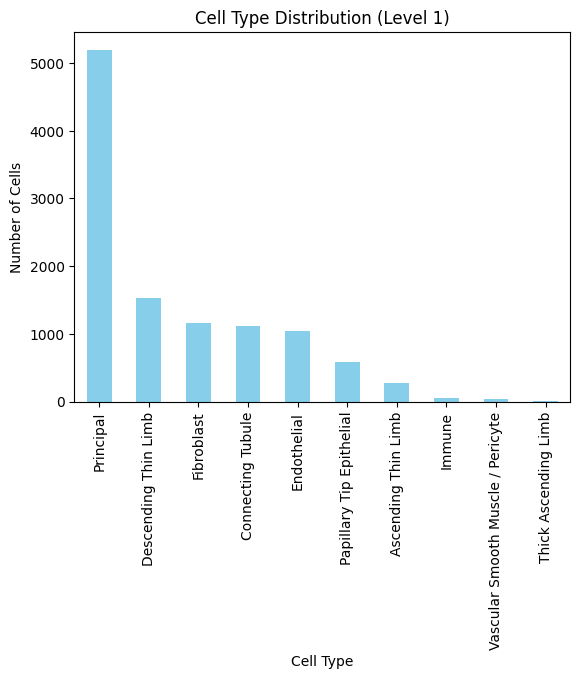

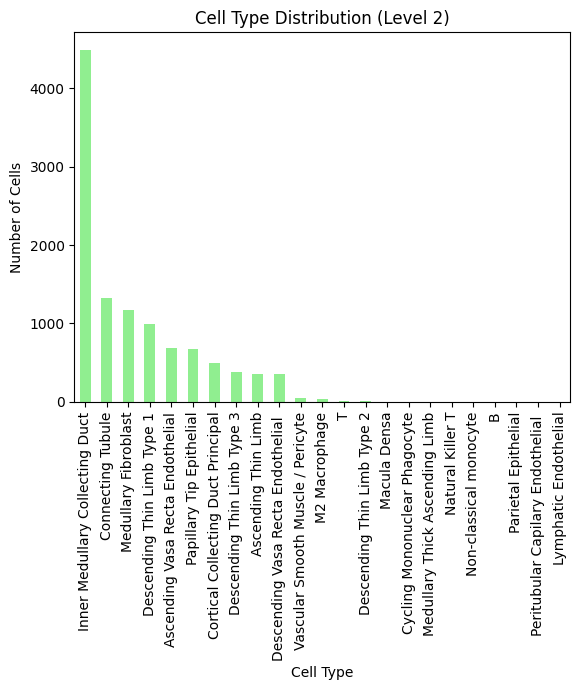

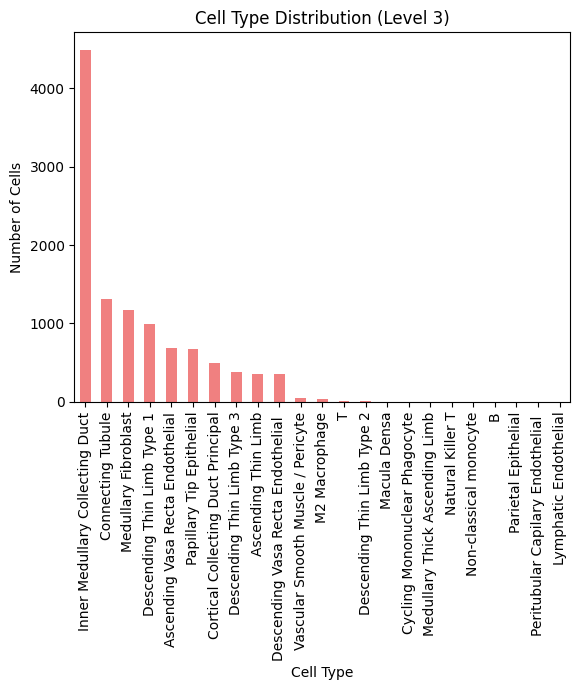

In [15]:
# Plot the distribution of cells per predicted cell type for l1
cell_type_counts_l1.plot(kind='bar', color='skyblue')
plt.title('Cell Type Distribution (Level 1)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

# Plot the distribution of cells per predicted cell type for l2
cell_type_counts_l2.plot(kind='bar', color='lightgreen')
plt.title('Cell Type Distribution (Level 2)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

# Plot the distribution of cells per predicted cell type for l3
cell_type_counts_l3.plot(kind='bar', color='lightcoral')
plt.title('Cell Type Distribution (Level 3)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

In [16]:
adata

AnnData object with n_obs × n_vars = 19339 × 10996
    obs: 'predicted_l1', 'predicted_l2', 'predicted_l3'

In [ ]:
import scanpy as sc

# Perform PCA (principal component analysis) first
sc.tl.pca(adata, svd_solver='arpack')

# Optionally, you can visualize the variance explained by each component
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)